In [ ]:
import torch
import pandas as pd
import numpy as np
from utils.GraphConvolution import GCN_Encoder_s, GCN_Classifier_s, Decoder_s
from utils.GraphConvolution import GraphConvolution, GCN_Encoder3
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from tqdm.notebook import tqdm
from scipy.io import loadmat
import utils
from collections import defaultdict
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc

Initialization

In [ ]:
class Args:
    weight_decay = 5e-4
    epochs = 1500
    learning_rate = 0.01
    learning_rate_W = 0.01
    dropout = 0.5
    dropout_W = 0.5
    gamma = 1
    no_cuda = False
    train_ratio=0.6
    test_ratio=0.2
    n_classes = 2
    seed = 12345
    torch.manual_seed(seed)
    dataset = "cora"
    # dataset = "haberman"
    # dataset = "diabetes"
    order = 4
    n_features = 0
    w_val_size = 10
    # imbalance_ratio = None
    imbalance_ratio = None
    n_hidden = 64
    setting = None
    im_class_num = 1
    setting = "upsampling"
    opt_new_G = False
    up_scale = 1
    im_ratio = 0.5
    val_size = 10
args = Args()


Dataset specific variables

In [ ]:
from utils.data_loader import data_loader_diabetes, data_loader_haberman, data_loader_cora

cora_adj_mtx, cora_labels_df, cora_features_df, \
        cora_train_idx, cora_val_idx, cora_test_idx, cora_n_features = data_loader_cora(args)
        
diabetes_adj_mtx, diabetes_labels_df, diabetes_features_df, \
        diabetes_train_idx, diabetes_val_idx, diabetes_test_idx, diabetes_n_features = data_loader_diabetes(args)

haberman_adj_mtx, haberman_labels_df, haberman_features_df, \
        haberman_train_idx, haberman_val_idx, haberman_test_idx, haberman_n_features = data_loader_haberman(args)

if args.dataset == "diabetes":
    adj_mtx = diabetes_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = diabetes_n_features
    features = diabetes_features_df
    labels = diabetes_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = diabetes_train_idx
    val_idx = diabetes_val_idx
    test_idx = diabetes_test_idx
elif args.dataset == "cora":
    adj_mtx = cora_adj_mtx
    n_hidden = [64, 64, 64]
    n_features = cora_n_features
    features = cora_features_df
    labels = cora_labels_df
    # train_X = diabetes_train_X_df
    # train_Y = diabetes_train_Y_df
    # val_X = diabetes_val_X_df
    # val_Y = diabetes_val_Y_df
    # test_X = diabetes_test_X_df
    # test_Y = diabetes_test_Y_df
    train_idx = cora_train_idx
    val_idx = cora_val_idx
    test_idx = cora_test_idx
elif args.dataset == "haberman":
    adj_mtx = haberman_adj_mtx
    n_hidden = [64]
    n_features = haberman_n_features
    features = haberman_features_df
    labels = haberman_labels_df
    # train_X = haberman_train_X_df
    # train_Y = haberman_train_Y_df
    # val_X = haberman_val_X_df
    # val_Y = haberman_val_Y_df
    # test_X = haberman_test_X_df
    # test_Y = haberman_test_Y_df
    train_idx = haberman_train_idx
    val_idx = haberman_val_idx
    test_idx = haberman_test_idx
else:
    pass

In [ ]:
# assert len(pd.DataFrame(labels[train_idx])[0].unique()) == len(pd.DataFrame(labels[val_idx])[0].unique()) == len(pd.DataFrame(labels[test_idx])[0].unique()), \
    # "There are some classes missing in one the 3 partitiones of the dataset"

In [ ]:
device = torch.device("cuda" if False else "cpu")

Dataframe to Tensor transformation

In [ ]:
# features = torch.from_numpy(np.concatenate((train_X, val_X, test_X), axis=0)).to(device)
# labels = torch.from_numpy(np.int64(np.concatenate((train_Y, val_Y, test_Y), axis=0))).to(device)
train_idx = torch.from_numpy(np.array(train_idx, dtype = np.int64)).to(device)
val_idx = torch.from_numpy(np.array(val_idx, dtype = np.int64)).to(device)
test_idx = torch.from_numpy(np.array(test_idx, dtype = np.int64)).to(device)
features = torch.from_numpy(np.array(features, dtype = np.float64)).to(device)
labels = torch.from_numpy(np.array(labels, dtype = np.int64)).to(device)
try:
    adj_mtx = torch.from_numpy(np.array(adj_mtx, dtype = np.float64)).to(device)
except:
    pass

Baseline 2 layer Classifier trainer

In [ ]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc

encoder_n = GCN_Encoder3(nfeat=n_features,
        nhid=n_hidden,
        nembed=n_hidden[-1],
        dropout=args.dropout,
        nclass=args.n_classes,
        order=1)
classifier_n = GCN_Classifier(nembed=n_hidden[-1], 
        nhid=n_hidden[-1], 
        nclass=int(labels.max().item()) + 1, 
        dropout=args.dropout, device=device)

# encoder = GCN_Encoder_s(nfeat = n_features, nhid = n_hidden[-1], nembed = n_hidden[-1], dropout = args.dropout)
# classifier = GCN_Classifier_s(nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
# encoder_n = GCN_Encoder_w(nfeat = n_features, nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
# optimizer_n = optim.Adam(encoder_n.parameters(),
#                        lr = args.learning_rate, weight_decay = args.weight_decay)
optimizer_en = optim.Adam(encoder_n.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
optimizer_cls = optim.Adam(classifier_n.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
def train(epoch):
        encoder_n.train()
        classifier_n.train()
        t = time.time()
        optimizer_en.zero_grad()
        optimizer_cls.zero_grad()
        # optimizer_n.zero_grad()
        embed = encoder_n(features, adj_mtx)
        output = classifier_n(embed, adj_mtx)
        # output = encoder_n(features, adj_mtx)
        out = output[train_idx]
        gt = labels[train_idx].reshape(-1)
        if args.setting == 'reweight':
                weight = "STH"
                loss_train = F.cross_entropy(out, gt, weight = weight)
        else:
                loss_train = F.cross_entropy(out, gt)
        acc_train = accuracy(out, gt)
        loss_train.backward()
        optimizer_en.step()
        optimizer_cls.step()
        # encoder_n.step()
        gt_v = labels[val_idx].reshape(-1)
        out_v = output[val_idx]
        loss_val = F.cross_entropy(out_v, gt_v)
        acc_val = accuracy(out_v, gt_v)
        # print_class_acc(out_v, gt_v)
        print('Epoch: {:05d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
        print_class_acc(output[val_idx], labels[val_idx])
        return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


Baseline 2 layer Classifier test

In [ ]:
def test(epoch = 0):
    encoder_n.eval()
    classifier_n.eval()
#     outputs = encoder(features, adj_mtx)
    embed = encoder_n(features, adj_mtx)
    outputs = classifier_n(embed, adj_mtx)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx])
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')

Baseline 2 layer Classifier training process

In [ ]:
acc_trains = []
acc_vals = []
loss_trains = []
loss_vals = []

for epoch in tqdm(range(args.epochs)):
        acc_train, acc_val, loss_train, loss_val = train(epoch)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        loss_trains.append(loss_train)
        loss_vals.append(loss_val)
        if epoch % 10 == 0:
                test(epoch)

Saving the trained 2 layer classifier model

In [ ]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder_n.state_dict()
    saved_content['classifier'] = classifier_n.state_dict()
    torch.save(saved_content, 'checkpoint/{}/Normal_{}_{}.pth'.format(args.dataset, args.dataset, args.imbalance_ratio))
    return
save_model()

GraphSMOTE's trainer

In [ ]:
from copy import deepcopy

encoder_s = GCN_Encoder_s(nfeat=features.shape[1],
        nhid=args.n_hidden,
        nembed=args.n_hidden,
        dropout=args.dropout)
classifier_s = GCN_Classifier_s(nembed=args.n_hidden, 
        nhid=args.n_hidden, 
        nclass=labels.max().item() + 1, 
        dropout=args.dropout, device = device)
decoder_s = Decoder_s(nembed=args.n_hidden,
        dropout=args.dropout)
optimizer_en = optim.Adam(encoder_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer_cls = optim.Adam(classifier_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer_de = optim.Adam(decoder_s.parameters(),
                       lr=args.learning_rate, weight_decay=args.weight_decay)
def train(epoch):
    t = time.time()
    encoder_s.train()
    classifier_s.train()
    decoder_s.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder_s(features, adj_mtx)

    if args.setting == 'recon_newG' or args.setting == 'recon' or args.setting == 'newG_cls':
        ori_num = labels.shape[0]
        embed, labels_new, idx_train_new, adj_up = utils.recon_upsample(embed, labels, train_idx, adj = adj_mtx.detach().to_dense(), portion = args.up_scale, im_class_num = args.im_class_num)
        generated_G = decoder_s(embed)

        loss_rec = utils.adj_mse_loss(generated_G[: ori_num, :][:, : ori_num], adj_mtx.detach().to_dense())
        
        #ipdb.set_trace()


        if not args.opt_new_G:
            adj_new = copy.deepcopy(generated_G.detach())
            threshold = 0.5
            adj_new[adj_new < threshold] = 0.0
            adj_new[adj_new >= threshold] = 1.0

            #ipdb.set_trace()
            edge_ac = adj_new[: ori_num, : ori_num].eq(adj_mtx.to_dense()).double().sum()/(ori_num**2)
        else:
            adj_new = generated_G
            edge_ac = F.l1_loss(adj_new[: ori_num, : ori_num], adj_mtx.to_dense(), reduction = 'mean')


        #calculate generation information
        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new = torch.mul(adj_up, adj_new)

        exist_edge_prob = adj_new[:ori_num, :ori_num].mean() #edge prob for existing nodes
        generated_edge_prob = adj_new[ori_num:, :ori_num].mean() #edge prob for generated nodes
        print("after filtering, edge acc: {:.4f}, exist_edge_prob: {:.4f}, generated_edge_prob: {:.4f}".format(edge_ac.item(), exist_edge_prob.item(), generated_edge_prob.item()))


        adj_new[:ori_num, :][:, :ori_num] = adj_mtx.detach().to_dense()
        #adj_new = adj_new.to_sparse()
        #ipdb.set_trace()

        if not args.opt_new_G:
            adj_new = adj_new.detach()

        if args.setting == 'newG_cls':
            idx_train_new = train_idx

    elif args.setting == 'embed_up':
        #perform SMOTE in embedding space
        embed, labels_new, idx_train_new = utils.recon_upsample(embed, labels, train_idx, portion=args.up_scale, im_class_num = args.im_class_num)
        adj_new = adj_mtx
    else:
        labels_new = labels
        idx_train_new = train_idx
        adj_new = adj_mtx

    #ipdb.set_trace()
    output = classifier_s(embed, adj_new)



    if args.setting == 'reweight':
        weight = features.new((labels.max().item() + 1)).fill_(1)
        weight[-args.im_class_num:] = 1 + args.up_scale
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1), weight=weight)
    else:
        loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new].reshape(-1))

    acc_train = accuracy(output[train_idx], labels_new[train_idx].reshape(-1))
    if args.setting == 'recon_newG':
        loss = loss_train + loss_rec * args.rec_weight
    elif args.setting == 'recon':
        loss = loss_rec + 0 * loss_train
    else:
        loss = loss_train
        loss_rec = loss_train

    loss.backward()
    if args.setting == 'newG_cls':
        optimizer_en.zero_grad()
        optimizer_de.zero_grad()
    else:
        optimizer_en.step()

    optimizer_cls.step()

    if args.setting == 'recon_newG' or args.setting == 'recon':
        optimizer_de.step()

    loss_val = F.cross_entropy(output[val_idx], labels[val_idx].reshape(-1))
    acc_val = accuracy(output[val_idx], labels[val_idx].reshape(-1))

    print('Epoch: {:05d}'.format(epoch + 1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

GraphSOMTE's test

In [ ]:
def test(epoch = 0):
    encoder_s.eval()
    classifier_s.eval()
#     outputs = encoder(features, adj_mtx)
    embed = encoder_s(features, adj_mtx)
    outputs = classifier_s(embed, adj_mtx)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx])
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')

GraphSOMTE's training process

In [ ]:
for epoch in tqdm(range(args.epochs)):
        train(epoch, features, labels)
        if epoch % 10 == 0:
                test(epoch)

Saving the trained GraphSMOTE's model

In [ ]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder_s.state_dict()
    saved_content['classifier'] = classifier_s.state_dict()
    saved_content['decoder'] = decoder_s.state_dict()
    torch.save(saved_content, 'checkpoint/{}/GraphSMOTE_{}_{}.pth'.format(args.dataset, args.dataset, args.imbalance_ratio))
    return
save_model()

Reweight model's train

In [ ]:
from utils.GraphConvolution import GCN_Encoder3, GCN_Classifier, GCN_Encoder_w
import time
import torch.optim as optim
import torch.nn.functional as F
from utils.evaluation import accuracy, print_class_acc
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
import copy
from torch import autograd
import higher
import itertools
from utils.reweight import next, next2
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(all="ignore")


# encoder = GCN_Encoder3(nfeat=n_features,
#         nhid=n_hidden,
#         nembed=n_hidden[-1],
#         dropout=args.dropout,
#         nclass=args.n_classes,
#         order=1)
# classifier = GCN_Classifier(nembed=n_hidden[-1], 
#         nhid=n_hidden[-1], 
#         nclass=int(labels.max().item()) + 1, 
#         dropout=args.dropout, device=device)
encoder = GCN_Encoder_w(nfeat = n_features, nembed = n_hidden[-1], nhid = n_hidden[-1], nclass = int(labels.max().item()) + 1, dropout = args.dropout, device = device)
optimizer = optim.Adam(encoder.parameters(),
                       lr = args.learning_rate, weight_decay = args.weight_decay)
# criterion = nn.BCEWithLogitsLoss().to(device)
def train(epoch, features, labels):
        encoder.train()
        # classifier.train()
        t = time.time()
        optimizer.zero_grad()
        with higher.innerloop_ctx(encoder, optimizer) as (meta_model, meta_opt):
                meta_train_outputs = meta_model(features, adj_mtx)
                # criterion.reduction = 'none'
                # new_labels = F.one_hot(labels, num_classes=int(labels.max().item()) + 1).double()
                meta_train_loss = F.cross_entropy(meta_train_outputs[train_idx], labels[train_idx])
                # meta_train_loss = criterion(meta_train_outputs[train_idx], new_labels[train_idx])
                eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=device)
                meta_train_loss = torch.sum(eps * meta_train_loss)
                meta_opt.step(meta_train_loss)
                sampled_val_idx, new_adj_mtx, new_features, new_labels = next(args, features, labels, val_idx, adj_mtx)
                # meta_inputs, meta_labels = next(args, features, labels, val_idx, adj_mtx)
                meta_val_idx, meta_adj_mtx, meta_features, meta_labels = sampled_val_idx.to(device=device, non_blocking=True), \
                        new_adj_mtx.to(device=device, non_blocking=True), \
                        new_features.to(device=device, non_blocking=True), \
                        new_labels.to(device=device, non_blocking=True)
                meta_val_outputs = meta_model(meta_features, meta_adj_mtx.double())
                # criterion.reduction = 'mean'
                # new_meta_labels = F.one_hot(meta_labels, num_classes=int(labels.max().item()) + 1).double()
                meta_train_loss = F.cross_entropy(meta_val_outputs, meta_labels)
                # meta_val_loss = criterion(meta_val_outputs, new_meta_labels)
                eps_grads = torch.autograd.grad(meta_train_loss, eps)[0].detach()
        w_tilde = torch.clamp(-eps_grads, min=0)
        l1_norm = torch.sum(w_tilde)
        if l1_norm != 0:
                w = w_tilde / l1_norm
        else:
                w = w_tilde
        outputs = encoder(features, adj_mtx.double())
        # criterion.reduction = 'none'
        # new_main_labels = F.one_hot(labels, num_classes=int(labels.max().item()) + 1).double()
        loss = F.cross_entropy(outputs[train_idx], labels[train_idx])
        # loss = criterion(outputs[train_idx], new_main_labels[train_idx])
        loss = torch.sum(w * loss)

        loss_train = F.cross_entropy(outputs[train_idx], labels[train_idx].reshape(-1))
        acc_train = accuracy(outputs[train_idx], labels[train_idx].reshape(-1))

        loss.backward()
        optimizer.step()

        loss_val = F.cross_entropy(outputs[val_idx], labels[val_idx].reshape(-1))
        acc_val = accuracy(outputs[val_idx], labels[val_idx].reshape(-1))

        print('Epoch: {:05d}'.format(epoch + 1),
                'loss_train: {:.4f}'.format(loss_train.item()),
                'acc_train: {:.4f}'.format(acc_train.item()),
                'loss_val: {:.4f}'.format(loss_val.item()),
                'acc_val: {:.4f}'.format(acc_val.item()),
                'time: {:.4f}s'.format(time.time() - t))
                
        # keep track of epoch loss/accuracy
        # train_loss += loss.item() * outputs.shape[0]

                # out = output[train_idx]
                # gt = labels[train_idx].reshape(-1)
                # if args.setting == 'reweight':
                #         weight = "STH"
                #         loss_train = F.cross_entropy(out, gt, weight = weight)
                # else:
                #         loss_train = F.cross_entropy(out, gt)
                # acc_train = accuracy(out, gt)
                # loss_train.backward()
                # optimizer_en.step()
                # optimizer_cls.step()
                # gt_v = labels[test_idx].reshape(-1)
                # out_v = output[test_idx]
                # loss_val = F.cross_entropy(out_v, gt_v)
                # acc_val = accuracy(out_v, gt_v)
                # # print_class_acc(out_v, gt_v)
                # print('Epoch: {:05d}'.format(epoch+ 1),
                # 'loss_train: {:.4f}'.format(loss_train.item()),
                # 'acc_train: {:.4f}'.format(acc_train.item()),
                # 'loss_val: {:.4f}'.format(loss_val.item()),
                # 'acc_val: {:.4f}'.format(acc_val.item()),
                # 'time: {:.4f}s'.format(time.time() - t))
                
        # return acc_train.item(), acc_val.item(), loss_train.item(), loss_val.item()


Reweight model's test

In [ ]:
def test(epoch = 0):
    encoder.eval()
    outputs = encoder(features, adj_mtx)
    loss_test = F.cross_entropy(outputs[test_idx], labels[test_idx])
    acc_test = accuracy(outputs[test_idx], labels[test_idx])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

    print_class_acc(outputs[test_idx], labels[test_idx], pre='test')

Reweight model's train and testing process

In [ ]:
for epoch in tqdm(range(args.epochs)):
        train(epoch, features, labels)
        if epoch % 10 == 0:
                test(epoch)

Saving the reweight model

In [ ]:
def save_model():
    saved_content = {}
    saved_content['encoder'] = encoder.state_dict()
    torch.save(saved_content, 'checkpoint/{}/Reweight_{}_{}.pth'.format(args.dataset, args.dataset, args.imbalance_ratio))
    return
save_model()

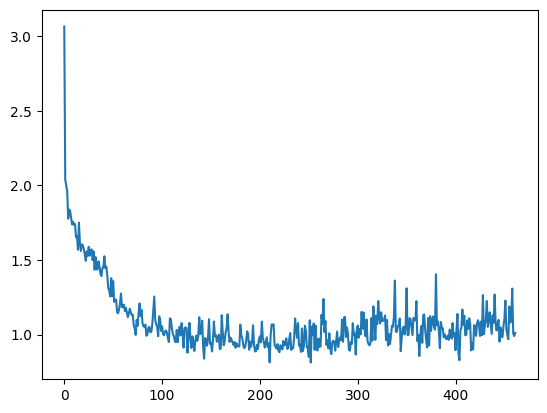

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

# %matplotlib notebook
# %matplotlib inline

plt.plot(loss_vals)

plt.show()